In [53]:
## all imports
import requests
from bs4 import BeautifulSoup
import time
import operator
import socket
#import cPickle
import re # regular expressions
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

import pandas as pd
from pandas import DataFrame
import missingno as msno
import pandas_profiling

import seaborn as sns
sns.set_context("talk")
sns.set_style("white")

#from secret import *

#This code is to import the libraries we will ptentially be using during the execution of the tasks I have been assigned to
# data analysis and wrangling
import pandas as pd
import pickle
import numpy as np
import random as rnd
from datetime import timedelta
import scipy
from scipy import stats
#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# machine learning and metrics
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, make_scorer, mean_squared_error
from sklearn.model_selection import KFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet, Lasso, SGDRegressor, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor,GradientBoostingRegressor,RandomForestRegressor
from sklearn.svm import SVC, LinearSVC, SVR, LinearSVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')
import urllib
import urllib.request
import os
from string import ascii_lowercase
import csv

In [24]:
#import list of names of players you want to scrape
FiveH_href=pd.read_csv('datasets/hrefs-players_final.csv')
playerlist=FiveH_href.iloc[:,0]

#In a previous version of the list I had a problem with line 253, which I had to delete
#playerlist.pop(253)


In [25]:
#create function to retrieve urls
def createNewUrl(player):
    player_splitted=player.split("/")
    url="https://www.transfermarkt.co.uk/"+player_splitted[1]+"/leistungsdatendetails/spieler/"+player_splitted[4]
    return(url)

In [27]:
#create function to scrape/add time-lag

def scrape_url(url_player):
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; rv:63.0) Gecko/20100101 Firefox/63.0'}
    try:
        response_detailed = requests.get(url, headers=headers, timeout=10)
        response_detailed.raise_for_status()

    except Exception:
        return None
    time.sleep(30)
    soup = BeautifulSoup(response_detailed.text,"html.parser")
    return(soup)

In [28]:
#retrieving items from table of player's stats
def wrangling_soup(soup):
    data = []
    table = soup.find('table', attrs={'class':'items'})
    table_body = table.find('tbody')

    rows = table_body.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele])
    return(data)



In [1]:
#saving stats in csv file
with open("players_stats_total.csv", "w") as f:
    writer = csv.writer(f,delimiter=',')
    for player in playerlist:
        url=createNewUrl(player)
        soup=scrape_url(url)
        data=wrangling_soup(soup)
        
        for i in data:
            i.insert(0,url)
            writer.writerow(i)
            

In [45]:
#importing scraped table into dataframe
players_stats=pd.read_csv('datasets/players_stats_total.csv',names=['Name','season','competition','apps','ppm','goals','assists','cards','mins_played'])

In [ ]:
#don't run following coded-window: it has already been done.
#I kept to give an idea about how messy were the data

In [ ]:
#correcting for some columns switches in the website
players_stats["assists"][players_stats["names"]=="emiliano viviano"]=players_stats["yellow_1/yellow_2/red"]
players_stats["assists"][players_stats["names"]=="sebastien frey"]=players_stats["yellow_1/yellow_2/red"]
players_stats["assists"][players_stats["names"]=="eduardo"]=players_stats["yellow_1/yellow_2/red"]
players_stats["assists"][players_stats["names"]=="neto"]=players_stats["yellow_1/yellow_2/red"]
players_stats["assists"][players_stats["names"]=="maksym koval"]=players_stats["yellow_1/yellow_2/red"]
players_stats["assists"][players_stats["names"]=="federico marchetti"]=players_stats["yellow_1/yellow_2/red"]
players_stats["assists"][players_stats["names"]=="marco storari"]=players_stats["yellow_1/yellow_2/red"]
players_stats["assists"][players_stats["names"]=="roberto"]=players_stats["yellow_1/yellow_2/red"]
players_stats["assists"][players_stats["names"]=="ben foster"]=players_stats["yellow_1/yellow_2/red"]
players_stats["assists"][players_stats["names"]=="bernd leno"]=players_stats["yellow_1/yellow_2/red"]
players_stats["assists"][players_stats["names"]=="eduardo"]=players_stats["goals"]
players_stats["assists"][players_stats["names"]=="diego lopez"]=players_stats["yellow_1/yellow_2/red"]
players_stats["assists"][players_stats["names"]=="anders lindegaard"]=players_stats["yellow_1/yellow_2/red"]
players_stats["assists"][players_stats["names"]=="vladimir gabulov"]=players_stats["yellow_1/yellow_2/red"]
players_stats["assists"][players_stats["names"]=="ali al habsi"]=players_stats["yellow_1/yellow_2/red"]
players_stats["assists"][players_stats["names"]=="salvatore sirigu"]=players_stats["yellow_1/yellow_2/red"]
players_stats["assists"][players_stats["names"]=="shay given"]=players_stats["yellow_1/yellow_2/red"]
players_stats.iloc[6526]

In [46]:
#players_stats.drop(["league","PPM","yellow_1/yellow_2/red"], axis=1,inplace=True)
#for i in range(len(players_stats.season)):
    #players_stats.season.iloc[i]=("20"+players_stats.season.iloc[i][3:])
#replacing some re and converting variables to numeric
cols=["goals","ppm","apps","assists", "mins_played"]
for i in cols:
    players_stats[i]=players_stats[i].str.replace(',','.', regex=True)
    players_stats[i]=players_stats[i].str.replace('-','', regex=True)
    players_stats[i]=players_stats[i].str.replace(" /  / ","", regex=True)
    players_stats[i]=players_stats[i].str.replace("/","", regex=True)
    players_stats[i]=players_stats[i].str.replace(" ","", regex=True)
    players_stats[i]=players_stats[i].str.replace("'","", regex=True)
    players_stats[i]=players_stats[i].str.replace("    ","", regex=True)
    players_stats[i]=pd.to_numeric(players_stats[i], errors='coerce')

In [47]:
#sanity check
players_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36505 entries, 0 to 36504
Data columns (total 9 columns):
Name           36505 non-null object
season         36505 non-null object
competition    36505 non-null object
apps           34607 non-null float64
ppm            34607 non-null float64
goals          15462 non-null float64
assists        12951 non-null float64
cards          36505 non-null object
mins_played    34189 non-null float64
dtypes: float64(5), object(4)
memory usage: 2.5+ MB


In [48]:
#cleaning Name column from url
for i in range(len(players_stats)):
    players_stats['Name'][i].split('/')
players_stats['Name']=players_stats['Name'].str.replace('https://www.transfermarkt.co.uk/','', regex=True)
players_stats['Name']=players_stats['Name'].str.replace('/leistungsdatendetails/spieler','', regex=True)
players_stats['Name']=players_stats['Name'].str.replace('-',' ', regex=True)
players_stats['Name']=players_stats['Name'].str.split('/').str[0]


In [49]:
players_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36505 entries, 0 to 36504
Data columns (total 9 columns):
Name           36505 non-null object
season         36505 non-null object
competition    36505 non-null object
apps           34607 non-null float64
ppm            34607 non-null float64
goals          15462 non-null float64
assists        12951 non-null float64
cards          36505 non-null object
mins_played    34189 non-null float64
dtypes: float64(5), object(4)
memory usage: 2.5+ MB


Number of variables,9
Number of observations,36505
Total Missing (%),16.2%
Total size in memory,2.5 MiB
Average record size in memory,72.0 B
Numeric,5
Categorical,3
Boolean,0
Date,1
Text (Unique),0
Rejected,0


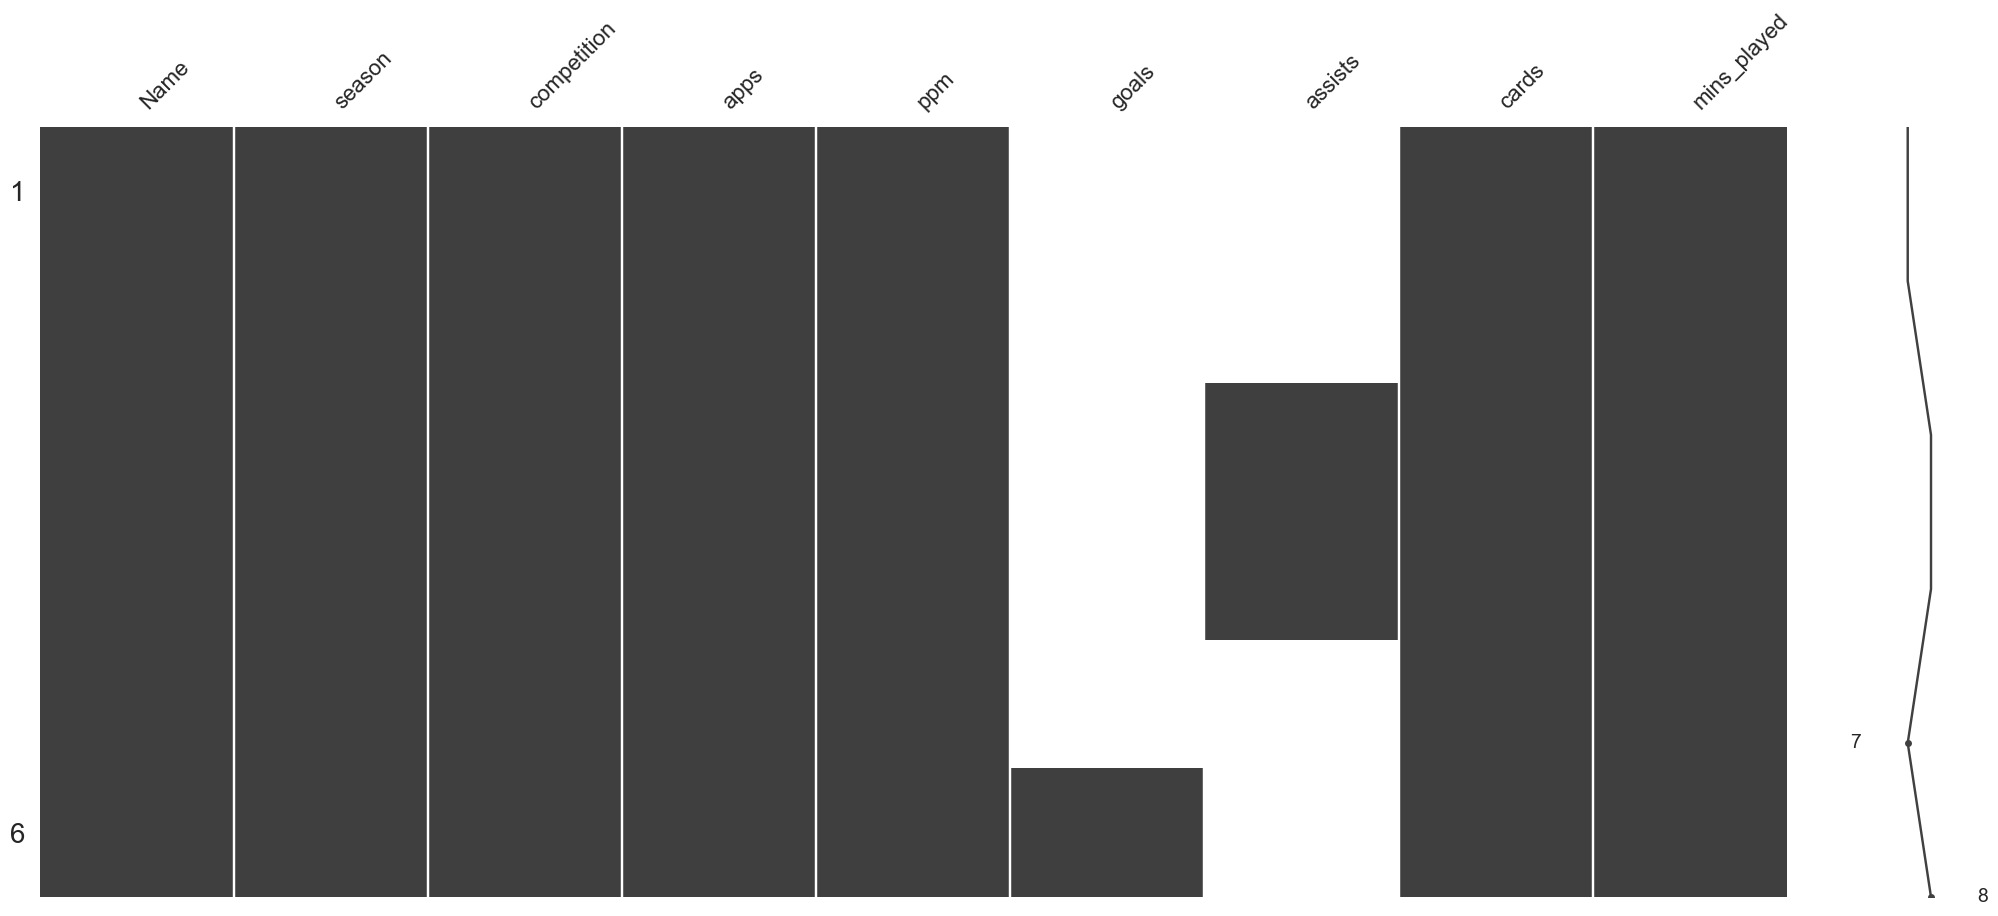

In [37]:
#using msno to plot distribution of missing values
msno.matrix(players_stats.sample(6))
#and pandas profiling to analyse them
pandas_profiling.ProfileReport(players_stats)

In [50]:
#dropping duplicates
players_stats.drop_duplicates(inplace=True)
#where are the nulls in goals
players_stats[players_stats['goals'].isnull()]


,Name,season,competition,apps,ppm,goals,assists,cards,mins_played
1,riccardo saponara,18/19,Coppa Italia,2.000,1.500,nan,1.000,- / - / -,131.000
2,riccardo saponara,17/18,Serie A,18.000,1.500,nan,4.000,3 / - / -,900.000
3,riccardo saponara,17/18,Coppa Italia,2.000,1.500,nan,nan,- / - / -,125.000
6,riccardo saponara,16/17,Europa League,nan,nan,nan,nan,- / - / -,nan
8,riccardo saponara,16/17,Coppa Italia,1.000,3.000,nan,nan,- / - / -,120.000
10,riccardo saponara,15/16,Coppa Italia,1.000,0.000,nan,nan,1 / - / -,90.000
12,riccardo saponara,14/15,Coppa Italia,1.000,0.000,nan,nan,- / - / -,56.000
13,riccardo saponara,14/15,Coppa Italia,nan,nan,nan,nan,- / - / -,nan
14,riccardo saponara,14/15,Serie A,1.000,0.000,nan,nan,- / - / -,90.000
15,riccardo saponara,13/14,Serie A,7.000,1.000,nan,nan,- / - / -,215.000


In [51]:
#fill the nans with 0
players_stats=players_stats.fillna(0)
players_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36500 entries, 0 to 36504
Data columns (total 9 columns):
Name           36500 non-null object
season         36500 non-null object
competition    36500 non-null object
apps           36500 non-null float64
ppm            36500 non-null float64
goals          36500 non-null float64
assists        36500 non-null float64
cards          36500 non-null object
mins_played    36500 non-null float64
dtypes: float64(5), object(4)
memory usage: 2.8+ MB


In [52]:
#creating competitions
minor_competition=[]
for i in players_stats['competition'].unique():
    if players_stats[players_stats['competition'] == i].shape[0] < 20:
        minor_competition.append(i)
for i,j in enumerate(players_stats['competition']):
    if j in minor_competition:
        players_stats['competition'].iloc[i]='others'
    

In [54]:
#drop cards
players_stats.drop(['cards'],axis=1,inplace=True)

In [55]:
#saving in csv file
players_stats.to_csv('players_stats_table.csv')

In [56]:
# Define a database name (we're using a dataset on births, so we'll call it birth_db)
# Set your postgres username/password, and connection specifics
username = 'postgres'
password = 'valentina'     # change this
host     = 'localhost'
port     = '5432'            # default port that postgres listens on
db_name  = 'market_value'
## 'engine' is a connection to a database
## Here, we're using postgres, but sqlalchemy can connect to other things too.
engine = create_engine( 'postgresql://{}:{}@{}:{}/{}'.format(username, password, host, port, db_name) )

In [57]:
# create table
players_stats.to_sql("Players_Performance", engine, if_exists='replace') 